## **Part 1 - Review Classification**

- Objective: Classify customer reviews into positive, negative, or neutral categories to help the company improve its products and services.
- Task: Create a model for classifying the textual content of reviews into these three categories.

#### Imports.

In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer,EarlyStoppingCallback






#### Load the Dataset.

In [ ]:
# Define dataset path
dataset_path = r'.\Dataset\cleaned_reviews.csv'

data = pd.read_csv(dataset_path, low_memory=False)

# Reset index 
data.reset_index(drop=True, inplace=True)

# Print dataset shape and column names for verification
print('Rows/Columns: ', data.shape)
print('Column Names: ', data.columns)

# Display first 10 rows
data.head(10)

rows/columns:  (59046, 6)
Column names:  Index(['name', 'brand', 'categories', 'reviews.doRecommend', 'reviews.rating',
       'reviews'],
      dtype='object')


,name,brand,categories,reviews.doRecommend,reviews.rating,reviews
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,Great device for reading. Definately pricey.. ...
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,"Excellent Kindle. The best Kindle ever, for me..."
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,4.0,Love it. I absolutely love this reader. The bi...
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,Good kindle. I always use it when i read ebook...
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,4.0,"So much to love, but slippery. Love bigger scr..."
5,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,4.0,Expensive but nice. I was used to the Kindle 3...
6,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,4.0,Like it. I love this so far only downside is y...
7,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,5.0,Love it!. I adore this kindle. I have owned vo...
8,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,5.0,"You get what you pay for. Best reader, super l..."
9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,5.0,Best Kindle ever..... This is the best Kindle ...


#### Mapping Star Ratings to Sentiment Classes.
-  1-2 stars → Negative
-  3 stars → Neutral
-  4-5 stars → Positive

In [12]:
# Define function to map ratings to sentiment categories
def map_sentiment(rating):
    if rating in [1, 2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:  # 4 or 5
        return "Positive"

# Apply mapping to create a new sentiment column
data['sentiment'] = data['reviews.rating'].apply(map_sentiment)

# Check distribution of sentiment labels
print(data['sentiment'].value_counts())



sentiment
Positive    54095
Neutral      2629
Negative     2322
Name: count, dtype: int64


#### **Model for classifyng: DistilBERT-base-uncased**


#### We split the dataset.

Due the imbalanced of our dataset we make sure we use Stratification in Train-Test Split.

In [13]:
# Prepare features and labels
X = data['reviews'].to_list()
y = data['sentiment'].to_list()

# Splitting the data into training (80%) and temp (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

# Splitting temp into validation (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Verify split sizes
print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")


Training set size: 47236
Validation set size: 5905
Test set size: 5905


#### Tokenize and load the Model

In [14]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the text data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=150)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=150)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=150)

# Display a sample of tokenized data
sample_tokens = tokenizer.convert_ids_to_tokens(train_encodings["input_ids"][0])
print(sample_tokens[:20])  # Show first 20 tokens of an example review


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

['[CLS]', 'great', 'deal', '!', '!', '.', 'this', 'work', 'great', 'so', 'far', '!', 'such', 'a', 'great', 'prices', 'i', 'was', 'waiting', 'for']


Creates a PyTorch Dataset class to handle input data

In [15]:
# Convert sentiment labels into numerical format
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]
test_labels = [label_map[label] for label in test_labels]

# Create a custom PyTorch Dataset class
class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)
test_dataset = ReviewsDataset(test_encodings, test_labels)



#### We train the model.

In [ ]:
# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)  #
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

# Define Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

# Train the Model
trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.144900,0.133152,0.957155,0.952354,0.957155,0.953356
2,0.097600,0.132496,0.966130,0.964139,0.966130,0.964538
3,0.069300,0.134815,0.970364,0.968803,0.970364,0.969364
4,0.039800,0.165490,0.970195,0.969269,0.970195,0.969683


TrainOutput(global_step=11812, training_loss=0.09541905778083323, metrics={'train_runtime': 1198.8543, 'train_samples_per_second': 197.005, 'train_steps_per_second': 12.316, 'total_flos': 7332822224683200.0, 'train_loss': 0.09541905778083323, 'epoch': 4.0})

#### **Evaluate the Model on the Test Set**

In [18]:
# Evaluate the trained model on the test set
test_results = trainer.evaluate(test_dataset)

# Print the test results
print("Test Set Evaluation Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

Test Set Evaluation Results:
eval_loss: 0.1217
eval_accuracy: 0.9695
eval_precision: 0.9681
eval_recall: 0.9695
eval_f1: 0.9685
eval_runtime: 10.7123
eval_samples_per_second: 551.2370
eval_steps_per_second: 34.5400
epoch: 4.0000


Model achieved an accuracy of 96.95% on the test dataset.
Class Negative: Precision=81.12%, Recall=87.07%, F1-score=83.99%
Class Neutral: Precision=73.39%, Recall=60.84%, F1-score=66.53%
Class Positive: Precision=98.62%, Recall=99.13%, F1-score=98.88%


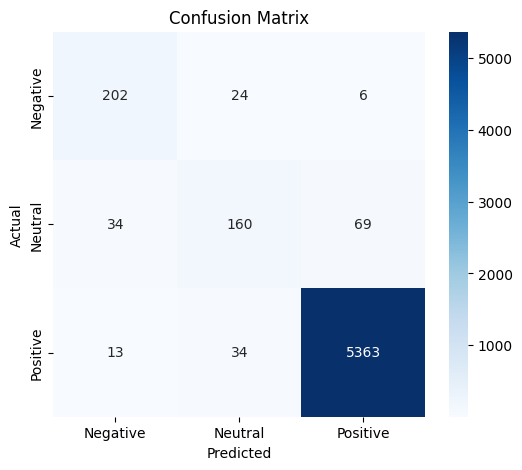

In [23]:
# Get predictions on test set
predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=1)  # Convert logits to class predictions

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

# Print results
print(f"Model achieved an accuracy of {accuracy*100:.2f}% on the test dataset.")
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    print(f"Class {class_name}: Precision={precision[i]*100:.2f}%, Recall={recall[i]*100:.2f}%, F1-score={f1[i]*100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Reload the original dataset to keep all columns
original_df = pd.read_csv(dataset_path)

# Apply sentiment mapping to the 'reviews.rating' column
def map_sentiment(rating):
    if rating in [1, 2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

original_df['sentiment'] = original_df['reviews.rating'].apply(map_sentiment)

# Save the new DataFrame with the sentiment column to a CSV
output_path = ".\cleaned_reviews_with_sentiment.csv"
original_df.to_csv(output_path, index=False)

output_path